In [110]:
import numpy as np
import pandas as pd

In [112]:
df = pd.read_csv('NIFTY 50_daily_data.csv')

In [114]:
pd.set_option('display.max_rows', None)

In [ ]:
df.info()

In [ ]:
# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Filter the data from 2020 onwards
df_filtered = df[df['date'] >= '2020-01-01'].reset_index(drop=True)

# Show the first few rows of the filtered dataset
df_filtered.head()

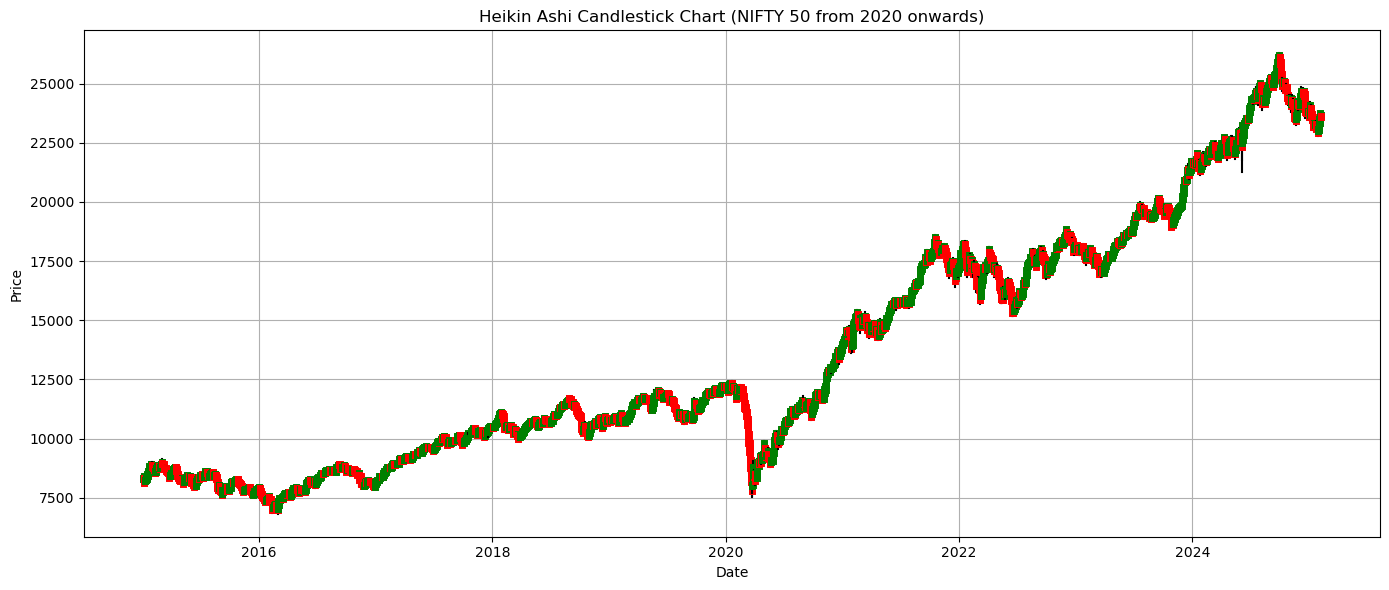

In [122]:
# Initialize a new DataFrame for Heikin Ashi candles
heikin_ashi = pd.DataFrame()
heikin_ashi['date'] = df['date']
heikin_ashi['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

# Calculate Heikin Ashi open prices
ha_open = [(df.loc[0, 'open'] + df.loc[0, 'close']) / 2]
for i in range(1, len(df)):
    ha_open.append((ha_open[i-1] + heikin_ashi['close'][i-1]) / 2)

heikin_ashi['open'] = ha_open
heikin_ashi['high'] = heikin_ashi[['open', 'close']].join(df['high']).max(axis=1)
heikin_ashi['low'] = heikin_ashi[['open', 'close']].join(df['low']).min(axis=1)

# Plot Heikin Ashi candlesticks
plt.figure(figsize=(14, 6))
for i in range(1, len(heikin_ashi)):
    color = 'green' if heikin_ashi['close'][i] >= heikin_ashi['open'][i] else 'red'
    plt.plot([heikin_ashi['date'][i], heikin_ashi['date'][i]],
             [heikin_ashi['low'][i], heikin_ashi['high'][i]], color='black')
    plt.plot([heikin_ashi['date'][i], heikin_ashi['date'][i]],
             [heikin_ashi['open'][i], heikin_ashi['close'][i]], color=color, linewidth=5)

plt.title('Heikin Ashi Candlestick Chart (NIFTY 50 from 2020 onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


💹 Sharpe Ratio (with TP/SL): 1.00
💹 Sharpe Ratio of the Strategy: 1.00


C:\Users\meetj\AppData\Local\Temp\ipykernel_5168\191090140.py:127: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
C:\Users\meetj\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


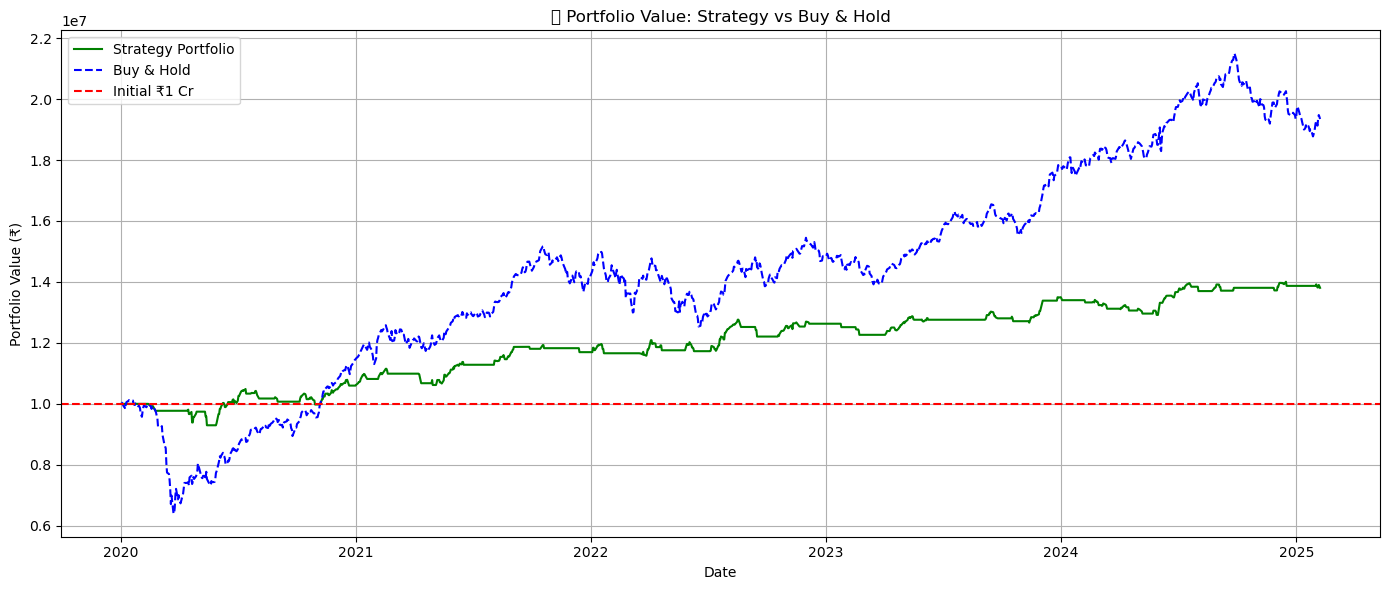

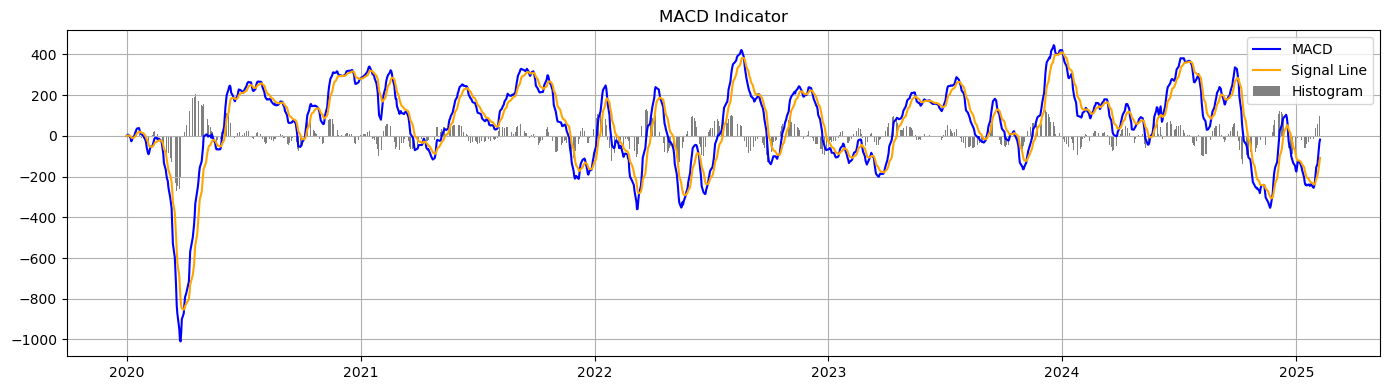

In [132]:
# 📦 Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# 🧾 Load Dataset
df = pd.read_csv("NIFTY 50_daily_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2020-01-01'].reset_index(drop=True)

# 📊 Heikin Ashi Candles
heikin_ashi = pd.DataFrame()
heikin_ashi['date'] = df['date']
heikin_ashi['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

ha_open = [(df.loc[0, 'open'] + df.loc[0, 'close']) / 2]
for i in range(1, len(df)):
    ha_open.append((ha_open[i-1] + heikin_ashi['close'][i-1]) / 2)

heikin_ashi['open'] = ha_open
heikin_ashi['high'] = heikin_ashi[['open', 'close']].join(df['high']).max(axis=1)
heikin_ashi['low'] = heikin_ashi[['open', 'close']].join(df['low']).min(axis=1)
heikin_ashi['HA_Close'] = heikin_ashi['close']

# 📈 Technical Indicators
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

def calculate_adx(df, period=14):
    high = df['high']
    low = df['low']
    close = df['close']
    plus_dm = high.diff()
    minus_dm = low.diff().abs()
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * (plus_dm.rolling(window=period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=period).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    return dx.rolling(window=period).mean()

# 💡 Add Indicators
heikin_ashi['RSI'] = calculate_rsi(heikin_ashi['HA_Close'])
heikin_ashi['MACD'], heikin_ashi['MACD_Signal'], heikin_ashi['MACD_Hist'] = calculate_macd(heikin_ashi['HA_Close'])
heikin_ashi['ADX'] = calculate_adx(df)
heikin_ashi['SMA_20'] = heikin_ashi['HA_Close'].rolling(window=20).mean()

# 🎯 Strategy Logic
def strategy(df):
    long = (df['HA_Close'] > df['SMA_20']) & (df['RSI'] > 50) & (df['MACD_Hist'] > 0) & (df['ADX'] > 20)
    short = (df['RSI'] < 50) & (df['MACD_Hist'] < 0) & (df['ADX'] < 20)
    signal = pd.Series(0, index=df.index)
    signal[long] = 1
    signal[short] = -1
    return signal

# 🎯 Enhanced Entry/Exit Logic with TP/SL
heikin_ashi['Signal'] = strategy(heikin_ashi)
heikin_ashi['Position'] = 0
entry_price = 0

for i in range(1, len(heikin_ashi)):
    if heikin_ashi['Signal'][i] != 0 and heikin_ashi['Position'][i-1] == 0:
        # Entry Signal
        entry_price = heikin_ashi['HA_Close'][i]
        heikin_ashi.loc[i, 'Position'] = heikin_ashi['Signal'][i]
    elif heikin_ashi['Position'][i-1] != 0:
        # Position Active - Check for TP/SL
        move = heikin_ashi['HA_Close'][i] - entry_price
        direction = heikin_ashi['Position'][i-1]
        
        if (direction == 1 and (move >= 150 or move <= -75)) or \
           (direction == -1 and (-move >= 150 or -move <= -75)):
            # TP or SL hit — Exit
            heikin_ashi.loc[i, 'Position'] = 0
            entry_price = 0
        else:
            # Continue Holding
            heikin_ashi.loc[i, 'Position'] = heikin_ashi['Position'][i-1]

# 🧮 Calculate Returns
initial_capital = 1e7  # ₹1 Crore
heikin_ashi['Return'] = heikin_ashi['HA_Close'].pct_change()
heikin_ashi['Strategy_Return'] = heikin_ashi['Position'].shift(1) * heikin_ashi['Return']
heikin_ashi['Cumulative_Strategy'] = (1 + heikin_ashi['Strategy_Return']).cumprod() * initial_capital
heikin_ashi['Cumulative_BuyHold'] = (1 + heikin_ashi['Return']).cumprod() * initial_capital

# 💹 Sharpe Ratio
sharpe = (heikin_ashi['Strategy_Return'].mean() / heikin_ashi['Strategy_Return'].std()) * np.sqrt(252)
print(f"💹 Sharpe Ratio (with TP/SL): {sharpe:.2f}")
heikin_ashi['Cumulative_Strategy'] = (1 + heikin_ashi['Strategy_Return']).cumprod() * initial_capital
heikin_ashi['Cumulative_BuyHold'] = (1 + heikin_ashi['Return']).cumprod() * initial_capital

sharpe = (heikin_ashi['Strategy_Return'].mean() / heikin_ashi['Strategy_Return'].std()) * np.sqrt(252)
print(f"💹 Sharpe Ratio of the Strategy: {sharpe:.2f}")

# 📈 Plotting Portfolio Growth
plt.figure(figsize=(14, 6))
plt.plot(heikin_ashi['date'], heikin_ashi['Cumulative_Strategy'], label="Strategy Portfolio", color='green')
plt.plot(heikin_ashi['date'], heikin_ashi['Cumulative_BuyHold'], label="Buy & Hold", color='blue', linestyle='--')
plt.axhline(initial_capital, color='red', linestyle='--', label='Initial ₹1 Cr')
plt.title("📊 Portfolio Value: Strategy vs Buy & Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio Value (₹)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 🔍 Optional: Plot Indicators (Example: MACD)
plt.figure(figsize=(14, 4))
plt.plot(heikin_ashi['date'], heikin_ashi['MACD'], label='MACD', color='blue')
plt.plot(heikin_ashi['date'], heikin_ashi['MACD_Signal'], label='Signal Line', color='orange')
plt.bar(heikin_ashi['date'], heikin_ashi['MACD_Hist'], label='Histogram', color='gray')
plt.title('MACD Indicator')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


💹 Sharpe Ratio: 0.96


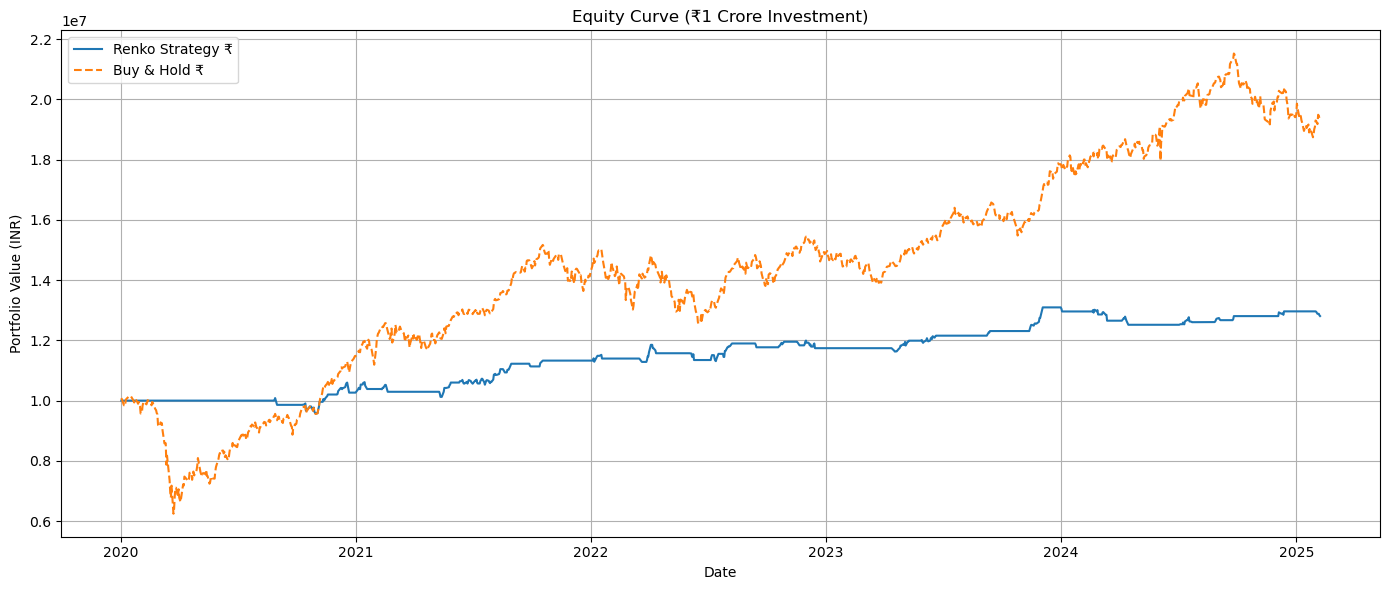

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and filter data
df = pd.read_csv("NIFTY 50_daily_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2020-01-01'].reset_index(drop=True)

# Initialize Renko
brick_size = 50
renko = df[['date', 'open', 'high', 'low', 'close']].copy()
direction = [0]
price = df['close'].iloc[0]

for close in df['close'].iloc[1:]:
    change = close - price
    if abs(change) >= brick_size:
        bricks = int(change / brick_size)
        direction.extend([1 if bricks > 0 else -1] * abs(bricks))
        price += bricks * brick_size
    else:
        direction.append(0)

while len(direction) < len(renko):
    direction.append(0)

renko['Direction'] = direction[:len(renko)]

# RSI
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

# MACD
def calculate_macd(series, fast=12, slow=26, signal=9):
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

# ADX
def calculate_adx(df, period=14):
    high = df['high']
    low = df['low']
    close = df['close']
    plus_dm = high.diff()
    minus_dm = low.diff().abs()
    plus_dm = plus_dm.where((plus_dm > minus_dm) & (plus_dm > 0), 0)
    minus_dm = minus_dm.where((minus_dm > plus_dm) & (minus_dm > 0), 0)
    tr1 = high - low
    tr2 = (high - close.shift()).abs()
    tr3 = (low - close.shift()).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * (plus_dm.rolling(window=period).mean() / atr)
    minus_di = 100 * (minus_dm.rolling(window=period).mean() / atr)
    dx = (abs(plus_di - minus_di) / (plus_di + minus_di)) * 100
    return dx.rolling(window=period).mean()

# Indicators
renko['RSI'] = calculate_rsi(renko['close'])
renko['MACD'], renko['MACD_Signal'], renko['MACD_Hist'] = calculate_macd(renko['close'])
renko['ADX'] = calculate_adx(renko)

# Strategy
renko['Position'] = 0
entry_price = 0
tp_points = 250
sl_points = 125

for i in range(1, len(renko)):
    if renko['Position'][i-1] == 0:
        if renko['Direction'][i] == 1 and renko['RSI'][i] > 60 and renko['MACD_Hist'][i] > 0 and renko['ADX'][i] > 20:
            renko.loc[i, 'Position'] = 1
            entry_price = renko['close'][i]
        elif renko['Direction'][i] == -1 and renko['RSI'][i] < 40 and renko['MACD_Hist'][i] < 0 and renko['ADX'][i] < 20:
            renko.loc[i, 'Position'] = -1
            entry_price = renko['close'][i]
    elif renko['Position'][i-1] == 1:
        move = renko['close'][i] - entry_price
        if move >= tp_points or move <= -sl_points:
            renko.loc[i, 'Position'] = 0
        else:
            renko.loc[i, 'Position'] = 1
    elif renko['Position'][i-1] == -1:
        move = entry_price - renko['close'][i]
        if move >= tp_points or move <= -sl_points:
            renko.loc[i, 'Position'] = 0
        else:
            renko.loc[i, 'Position'] = -1

# Performance
renko['Return'] = renko['close'].pct_change()
renko['Strategy_Return'] = renko['Position'].shift(1) * renko['Return']
renko['Cumulative_Strategy'] = (1 + renko['Strategy_Return']).cumprod() * 1e7
renko['Cumulative_BuyHold'] = (1 + renko['Return']).cumprod() * 1e7

# Sharpe Ratio
sharpe = (renko['Strategy_Return'].mean() / renko['Strategy_Return'].std()) * np.sqrt(252)
print(f"💹 Sharpe Ratio: {sharpe:.2f}")

# 📈 Plot
plt.figure(figsize=(14, 6))
plt.plot(renko['date'], renko['Cumulative_Strategy'], label='Renko Strategy ₹')
plt.plot(renko['date'], renko['Cumulative_BuyHold'], label='Buy & Hold ₹', linestyle='--')
plt.title('Equity Curve (₹1 Crore Investment)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


💹 Sharpe Ratio (Renko Strategy): 1.00


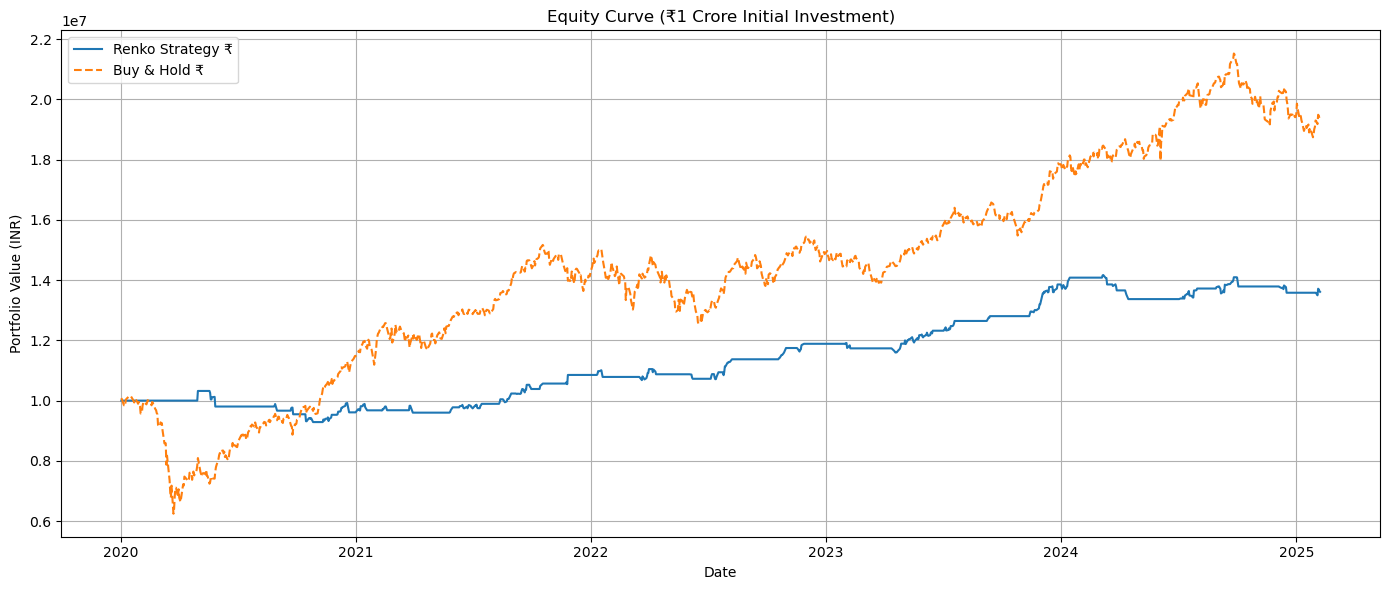

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and filter data
df = pd.read_csv("NIFTY 50_daily_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2020-01-01'].reset_index(drop=True)

# Initialize Renko candles from close prices
brick_size = 50
renko = df[['date', 'close']].copy()
direction = [0]
price = df['close'].iloc[0]

for close in df['close'].iloc[1:]:
    change = close - price
    if abs(change) >= brick_size:
        bricks = int(change / brick_size)
        direction.extend([1 if bricks > 0 else -1] * abs(bricks))
        price += bricks * brick_size
    else:
        direction.append(0)

while len(direction) < len(renko):
    direction.append(0)

renko['Direction'] = direction[:len(renko)]

# RSI
def calculate_rsi(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# MACD
def calculate_macd(close, fast=12, slow=26, signal=9):
    exp1 = close.ewm(span=fast, adjust=False).mean()
    exp2 = close.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

# ADX using close prices only (approximated logic)
def calculate_adx(close, period=14):
    high_low = close.diff().abs()  # simulate range
    plus_dm = close.diff().clip(lower=0)
    minus_dm = -close.diff().clip(upper=0)
    tr = high_low
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * plus_dm.rolling(window=period).mean() / atr
    minus_di = 100 * minus_dm.rolling(window=period).mean() / atr
    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    adx = dx.rolling(window=period).mean()
    return adx

# Apply indicators
renko['RSI'] = calculate_rsi(renko['close'])
renko['MACD'], renko['MACD_Signal'], renko['MACD_Hist'] = calculate_macd(renko['close'])
renko['ADX'] = calculate_adx(renko['close'])

# Strategy: Entry/Exit rules with dynamic 1% take profit
renko['Position'] = 0
entry_price = 0

for i in range(1, len(renko)):
    if renko['Position'][i-1] == 0:
        if (renko['Direction'][i] == 1 and renko['RSI'][i] > 60 and 
            renko['MACD_Hist'][i] > 0 and renko['ADX'][i] > 20):
            renko.loc[i, 'Position'] = 1
            entry_price = renko['close'][i]
        elif (renko['Direction'][i] == -1 and renko['RSI'][i] < 40 and 
              renko['MACD_Hist'][i] < 0 and renko['ADX'][i] < 20):
            renko.loc[i, 'Position'] = -1
            entry_price = renko['close'][i]
    elif renko['Position'][i-1] == 1:
        move = renko['close'][i] - entry_price
        tp_points = entry_price * 0.01
        sl_points = entry_price * 0.0125
        if move >= tp_points or move <= -sl_points:
            renko.loc[i, 'Position'] = 0
        else:
            renko.loc[i, 'Position'] = 1
    elif renko['Position'][i-1] == -1:
        move = entry_price - renko['close'][i]
        tp_points = entry_price * 0.01
        sl_points = entry_price * 0.0125
        if move >= tp_points or move <= -sl_points:
            renko.loc[i, 'Position'] = 0
        else:
            renko.loc[i, 'Position'] = -1

# Performance calculation
renko['Return'] = renko['close'].pct_change()
renko['Strategy_Return'] = renko['Position'].shift(1) * renko['Return']
renko['Cumulative_Strategy'] = (1 + renko['Strategy_Return']).cumprod() * 1e7
renko['Cumulative_BuyHold'] = (1 + renko['Return']).cumprod() * 1e7

# Sharpe Ratio
sharpe = (renko['Strategy_Return'].mean() / renko['Strategy_Return'].std()) * np.sqrt(252)
print(f"💹 Sharpe Ratio (Renko Strategy): {sharpe:.2f}")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(renko['date'], renko['Cumulative_Strategy'], label='Renko Strategy ₹')
plt.plot(renko['date'], renko['Cumulative_BuyHold'], label='Buy & Hold ₹', linestyle='--')
plt.title('Equity Curve (₹1 Crore Initial Investment)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


💹 Sharpe Ratio (Renko Strategy): 0.60


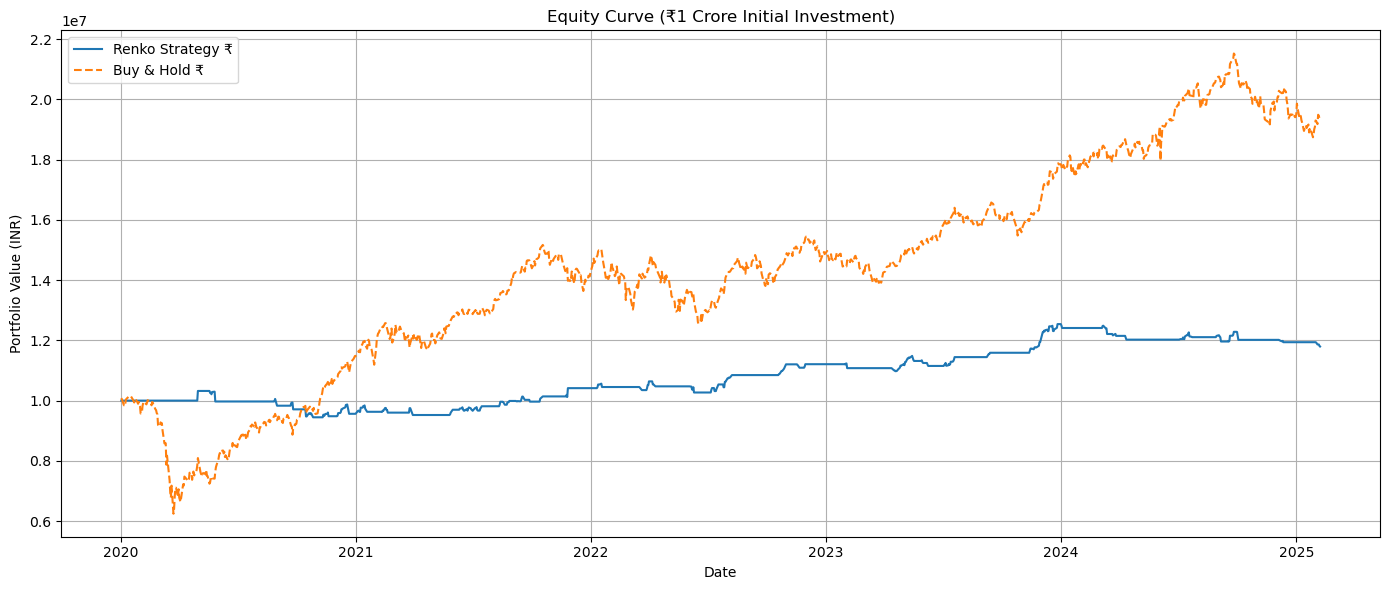

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and filter data
df = pd.read_csv("NIFTY 50_daily_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2020-01-01'].reset_index(drop=True)

# Initialize Renko candles from close prices
brick_size = 50
renko = df[['date', 'close']].copy()
direction = [0]
price = df['close'].iloc[0]

for close in df['close'].iloc[1:]:
    change = close - price
    if abs(change) >= brick_size:
        bricks = int(change / brick_size)
        direction.extend([1 if bricks > 0 else -1] * abs(bricks))
        price += bricks * brick_size
    else:
        direction.append(0)

while len(direction) < len(renko):
    direction.append(0)

renko['Direction'] = direction[:len(renko)]

# RSI
def calculate_rsi(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# MACD
def calculate_macd(close, fast=12, slow=26, signal=9):
    exp1 = close.ewm(span=fast, adjust=False).mean()
    exp2 = close.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

# ADX using close prices only (approximated logic)
def calculate_adx(close, period=14):
    high_low = close.diff().abs()  # simulate range
    plus_dm = close.diff().clip(lower=0)
    minus_dm = -close.diff().clip(upper=0)
    tr = high_low
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * plus_dm.rolling(window=period).mean() / atr
    minus_di = 100 * minus_dm.rolling(window=period).mean() / atr
    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    adx = dx.rolling(window=period).mean()
    return adx

# Apply indicators
renko['RSI'] = calculate_rsi(renko['close'])
renko['MACD'], renko['MACD_Signal'], renko['MACD_Hist'] = calculate_macd(renko['close'])
renko['ADX'] = calculate_adx(renko['close'])

# Strategy: Entry/Exit rules with TP = 1% and SL = 0.5% of entry price
renko['Position'] = 0
entry_price = 0

for i in range(1, len(renko)):
    if renko['Position'][i-1] == 0:
        if (renko['Direction'][i] == 1 and renko['RSI'][i] > 60 and 
            renko['MACD_Hist'][i] > 0 and renko['ADX'][i] > 20):
            renko.loc[i, 'Position'] = 1
            entry_price = renko['close'][i]
        elif (renko['Direction'][i] == -1 and renko['RSI'][i] < 40 and 
              renko['MACD_Hist'][i] < 0 and renko['ADX'][i] < 20):
            renko.loc[i, 'Position'] = -1
            entry_price = renko['close'][i]
    elif renko['Position'][i-1] == 1:
        move = renko['close'][i] - entry_price
        tp_points = entry_price * 0.01
        sl_points = entry_price * 0.005
        if move >= tp_points or move <= -sl_points:
            renko.loc[i, 'Position'] = 0
        else:
            renko.loc[i, 'Position'] = 1
    elif renko['Position'][i-1] == -1:
        move = entry_price - renko['close'][i]
        tp_points = entry_price * 0.01
        sl_points = entry_price * 0.005
        if move >= tp_points or move <= -sl_points:
            renko.loc[i, 'Position'] = 0
        else:
            renko.loc[i, 'Position'] = -1

# Performance calculation
renko['Return'] = renko['close'].pct_change()
renko['Strategy_Return'] = renko['Position'].shift(1) * renko['Return']
renko['Cumulative_Strategy'] = (1 + renko['Strategy_Return']).cumprod() * 1e7
renko['Cumulative_BuyHold'] = (1 + renko['Return']).cumprod() * 1e7

# Sharpe Ratio
sharpe = (renko['Strategy_Return'].mean() / renko['Strategy_Return'].std()) * np.sqrt(252)
print(f"💹 Sharpe Ratio (Renko Strategy): {sharpe:.2f}")

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(renko['date'], renko['Cumulative_Strategy'], label='Renko Strategy ₹')
plt.plot(renko['date'], renko['Cumulative_BuyHold'], label='Buy & Hold ₹', linestyle='--')
plt.title('Equity Curve (₹1 Crore Initial Investment)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (INR)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


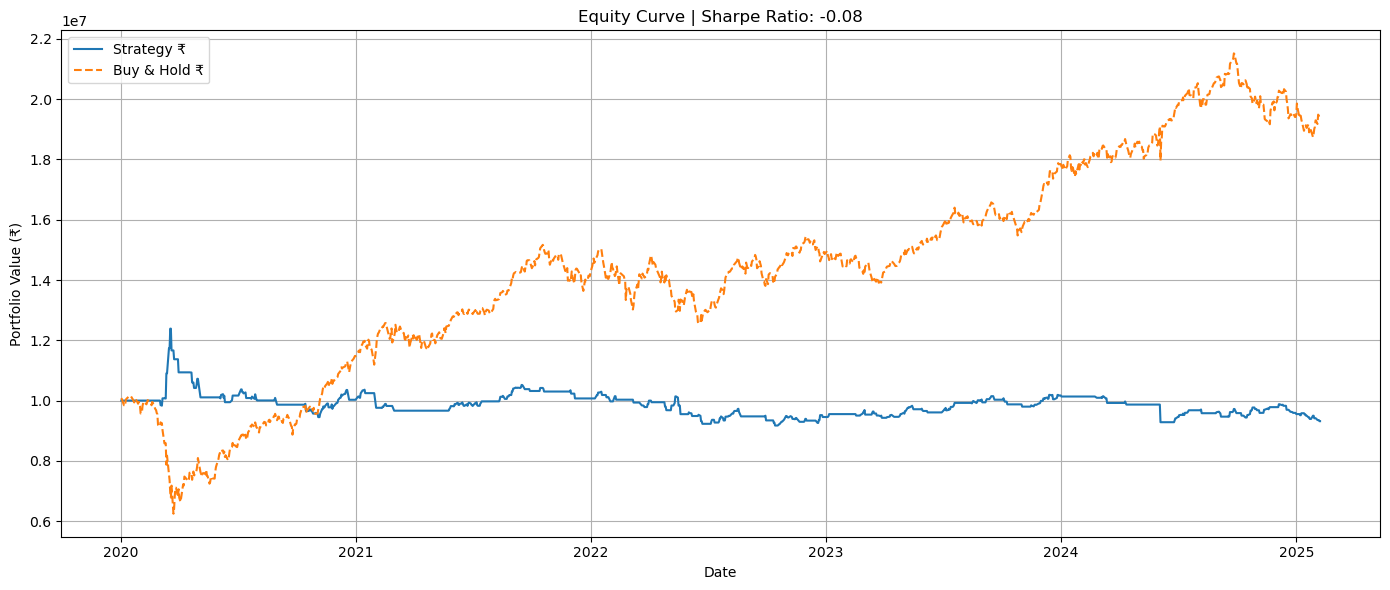

Sharpe Ratio: -0.08


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv("NIFTY 50_daily_data.csv")
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] >= '2020-01-01'].reset_index(drop=True)

# Calculate Heikin Ashi candles
HAdf = pd.DataFrame(index=df.index)
HAdf['real_close'] = df['close']
HAdf['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
HAdf['open'] = 0.0
HAdf.at[0, 'open'] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2
for i in range(1, len(df)):
    HAdf.at[i, 'open'] = (HAdf.at[i - 1, 'open'] + HAdf.at[i - 1, 'close']) / 2
HAdf['high'] = pd.concat([df['high'], HAdf['open'], HAdf['close']], axis=1).max(axis=1)
HAdf['low'] = pd.concat([df['low'], HAdf['open'], HAdf['close']], axis=1).min(axis=1)
HAdf['date'] = df['date']

# Indicator Functions
def calculate_rsi(close, period=14):
    delta = close.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_macd(close, fast=12, slow=26, signal=9):
    ema_fast = close.ewm(span=fast, adjust=False).mean()
    ema_slow = close.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist

def calculate_adx(close, period=14):
    high_low = close.diff().abs()
    plus_dm = close.diff().clip(lower=0)
    minus_dm = -close.diff().clip(upper=0)
    tr = high_low
    atr = tr.rolling(window=period).mean()
    plus_di = 100 * plus_dm.rolling(window=period).mean() / atr
    minus_di = 100 * minus_dm.rolling(window=period).mean() / atr
    dx = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    return dx.rolling(window=period).mean()

# Calculate indicators on real close
HAdf['RSI'] = calculate_rsi(HAdf['real_close'])
HAdf['MACD'], HAdf['MACD_Signal'], HAdf['MACD_Hist'] = calculate_macd(HAdf['real_close'])
HAdf['ADX'] = calculate_adx(HAdf['real_close'])

# Strategy Logic
HAdf['Position'] = 0
entry_price = 0
tp_points = 150  # Updated TP
sl_points = 75   # Updated SL

for i in range(1, len(HAdf)):
    prev_pos = HAdf['Position'][i-1]
    close_now = HAdf['real_close'][i]
    if prev_pos == 0:
        if (HAdf['close'][i] > HAdf['open'][i] and HAdf['RSI'][i] > 60 and 
            HAdf['MACD_Hist'][i] > 0 and HAdf['ADX'][i] > 19):  # ADX condition for long
            HAdf.at[i, 'Position'] = 1
            entry_price = close_now
        elif (HAdf['close'][i] < HAdf['open'][i] and HAdf['RSI'][i] < 40 and 
              HAdf['MACD_Hist'][i] < 0 and HAdf['ADX'][i] > 19):  # ADX condition for short
            HAdf.at[i, 'Position'] = -1
            entry_price = close_now
    elif prev_pos == 1:
        move = close_now - entry_price
        HAdf.at[i, 'Position'] = 0 if move >= tp_points or move <= -sl_points else 1
    elif prev_pos == -1:
        move = entry_price - close_now
        HAdf.at[i, 'Position'] = 0 if move >= tp_points or move <= -sl_points else -1

# Strategy performance
HAdf['Return'] = HAdf['real_close'].pct_change()
HAdf['Strategy_Return'] = HAdf['Position'].shift(1) * HAdf['Return']
HAdf['Cumulative_Strategy'] = (1 + HAdf['Strategy_Return']).cumprod() * 1e7
HAdf['Cumulative_BuyHold'] = (1 + HAdf['Return']).cumprod() * 1e7

# Sharpe Ratio
sharpe = (HAdf['Strategy_Return'].mean() / HAdf['Strategy_Return'].std()) * np.sqrt(252)

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(HAdf['date'], HAdf['Cumulative_Strategy'], label='Strategy ₹')
plt.plot(HAdf['date'], HAdf['Cumulative_BuyHold'], label='Buy & Hold ₹', linestyle='--')
plt.title(f"Equity Curve | Sharpe Ratio: {sharpe:.2f}")
plt.xlabel('Date')
plt.ylabel('Portfolio Value (₹)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Show Sharpe
print(f"Sharpe Ratio: {sharpe:.2f}")
